In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import category_encoders as ce

from haversine import haversine

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Инициализация и обзор данных

In [2]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [4]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте значения reviewer_score заполняем нулями

hotels = pd.concat([df_test, df_train], ignore_index=True).reset_index(drop=True) # объединяем

In [5]:
# Введем параметр valid, который позволит нам выбрасывать строки из обучающего множества
hotels['valid'] = 0
hotels.loc[hotels['sample'] == 1, 'valid'] = 1 # пока наше обучающее множество совпадает с исходным 

In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве;
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой выгрузки данных;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

# EDA

## Адрес отеля (hotel_address)

Из адреса можно извлечь довольно много информации. Сначала давайте узнаем, в какой стране находится каждый отель.

In [7]:
hotels['country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels.loc[hotels['country'] == 'Kingdom', 'country'] = 'United Kingdom'
hotels['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

Итак, мы рассматриваем отели из 6 разных стран: Великобритания, Испания, Франция, Нидерланды, Австрия и Италия. Теперт мы можем узнать для каждой страны медианную оценку, количество отелей и количество авторов отзывов. 

,country,reviewer_score,unique_hotels,reviwers_count
0,Austria,9.2,158,29178
1,France,8.8,458,44830
2,Italy,8.8,162,27883
3,Netherlands,8.8,105,43006
4,Spain,9.2,211,45132
5,United Kingdom,8.8,400,196774


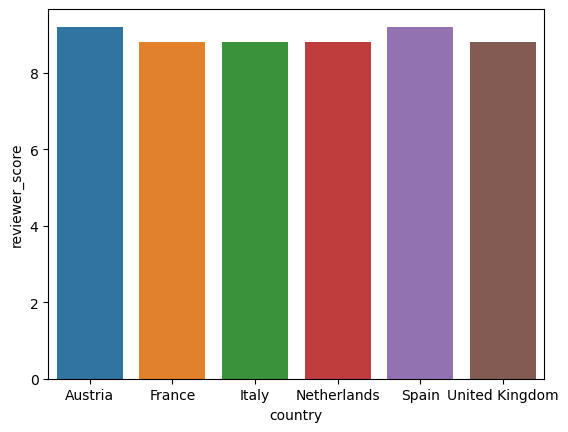

In [8]:
mask = hotels['sample'] == 1
# сгруппируем данные по новому признаку
for_plot = hotels[mask].groupby(by='country').agg({
    'reviewer_score' : 'median',
    'hotel_name' : pd.Series.nunique,
    'review_date' : 'count'
}).reset_index()
# переименуем столбцы для удобства
for_plot.rename(columns={
    'hotel_name' : 'unique_hotels',
    'review_date' : 'reviwers_count'
}, inplace=True)
sns.barplot(for_plot, x='country', y='reviewer_score')
for_plot

В Австрии и Испании самые высокие медианные оценки — 9.2, в остальных странах — 8.8.

<AxesSubplot:xlabel='country', ylabel='unique_hotels'>

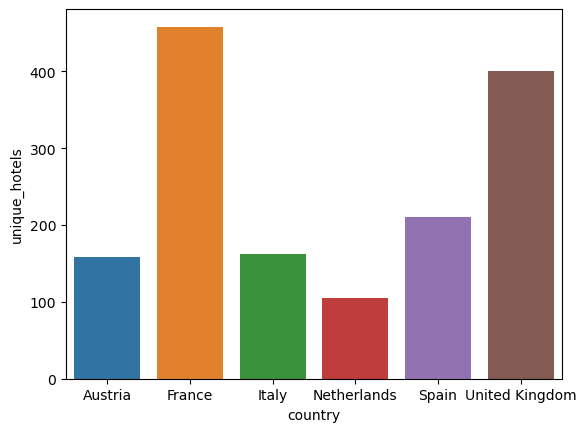

In [9]:
sns.barplot(for_plot, x='country', y='unique_hotels')

Больше всего отелей во Франции, дальше - Великобритания. Они с отрывом занимают первое и второе места.

<AxesSubplot:xlabel='country', ylabel='reviwers_count'>

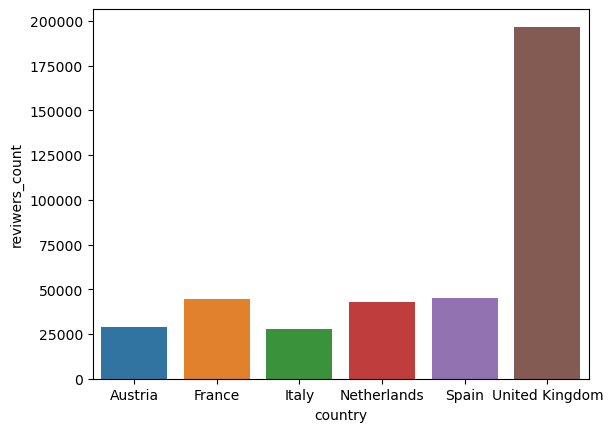

In [10]:
sns.barplot(for_plot, x='country', y='reviwers_count')

Больше всего отзывов оставили жители Великобритании. Закодируем этот признак.

In [11]:
ohe_enc = ce.OneHotEncoder(cols=['country'])
data_ohe = ohe_enc.fit_transform(hotels['country'])
categorical_columns = list() # список, в котором будем хранить категориальные признаки
categorical_columns.extend(data_ohe.columns)
hotels = pd.concat([hotels.copy(), data_ohe], axis=1)

In [12]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Дополнительное количество оценок без отзывов (additional_number_of_scoring)

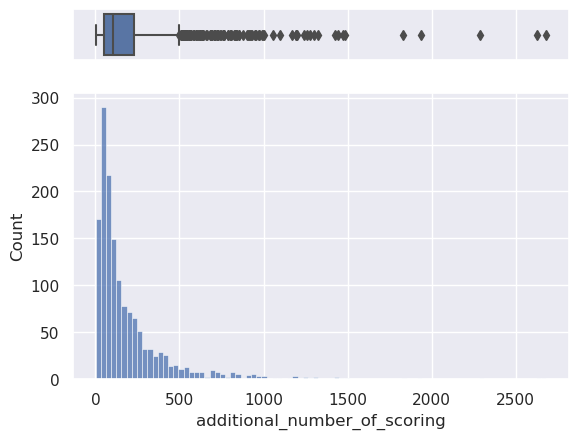

In [13]:
# для каждого отеля это постоянное значение, поэтому можно просто найти среднее
for_plot = hotels.groupby(by='hotel_name').agg({'additional_number_of_scoring' : 'mean'})
# фон
sns.set(style="darkgrid")
# рисунок с двумя объектами matplotlib.Axes (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
# создадим два графика ax
sns.boxplot(x=for_plot['additional_number_of_scoring'], ax=ax_box)
sns.histplot(data=for_plot, x='additional_number_of_scoring', ax=ax_hist)
# удалим подпись оси x для boxplot
ax_box.set(xlabel='')
plt.show()

Для большинства отелей дополнительное количество оценок не превышает 500.

<AxesSubplot:xlabel='additional_number_of_scoring', ylabel='reviewer_score'>

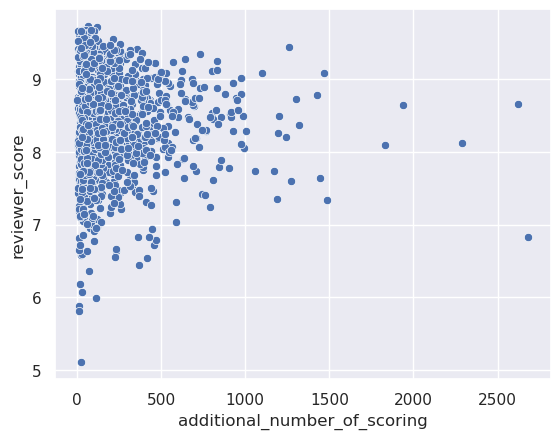

In [14]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='hotel_name').agg({'additional_number_of_scoring' : 'mean', 'reviewer_score' : 'mean'})
sns.scatterplot(data=for_plot, x="additional_number_of_scoring", y="reviewer_score")

Сложно говорить о какой-то зависимости средней оценки в отзывах от дополнительного количества оценок.

<AxesSubplot:xlabel='additional_number_of_scoring', ylabel='average_score'>

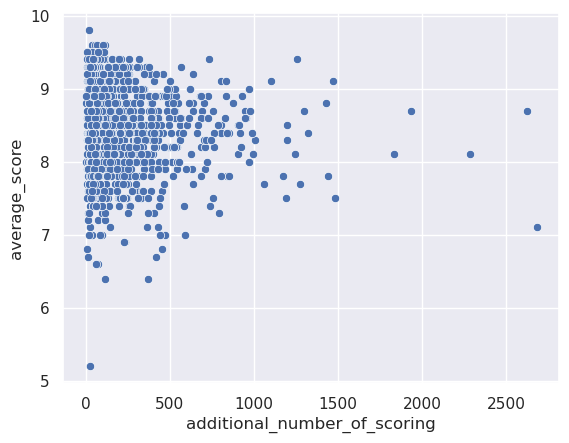

In [15]:
for_plot = hotels.groupby(by='hotel_name').agg({'additional_number_of_scoring' : 'mean', 'average_score' : 'mean'})
sns.scatterplot(data=for_plot, x="additional_number_of_scoring", y="average_score")

Для средней оценки тоже не наблюдается зависимость. Давайте для каждого отеля посчитаем соотношение количества дополнительных оценок и количества отзывов.

In [16]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='hotel_name').agg({
    'additional_number_of_scoring' : 'max',
    'total_number_of_reviews' : 'max',
    'reviewer_score' : 'mean',
    'average_score' : 'mean'
}).reset_index()
for_plot['rate'] = for_plot['additional_number_of_scoring'] / for_plot['total_number_of_reviews'] * 100
for_plot[[
    'hotel_name',
    'rate',
    'total_number_of_reviews',
    'reviewer_score',
    'average_score'
]].sort_values(by=['rate', 'total_number_of_reviews'])

,hotel_name,rate,total_number_of_reviews,reviewer_score,average_score
1482,XO Hotel,2.040816,49,8.720000,8.9
193,Ca Bianca Hotel Corte Del Naviglio,2.501895,1319,7.270769,7.7
1349,The Hub Hotel,3.620690,1160,7.144444,7.7
133,Best Western Hotel Major,3.884372,1107,8.030508,8.1
110,Barcel Milan,3.934325,3228,7.658046,8.1
...,...,...,...,...,...
191,COMO The Halkin,35.526316,76,9.223810,9.3
1327,The Connaught,36.054422,147,9.166667,9.3
188,Bulgari Hotel London,36.686391,169,9.530769,9.3
197,Canary Riverside Plaza Hotel,39.354839,310,9.000980,8.9


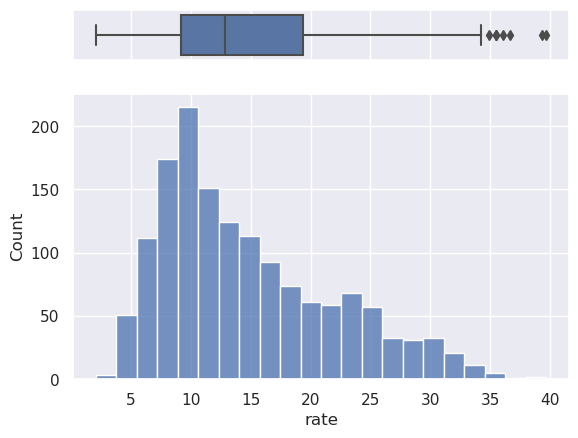

In [17]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=for_plot['rate'], ax=ax_box)
sns.histplot(data=for_plot, x='rate', ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

<AxesSubplot:xlabel='rate', ylabel='reviewer_score'>

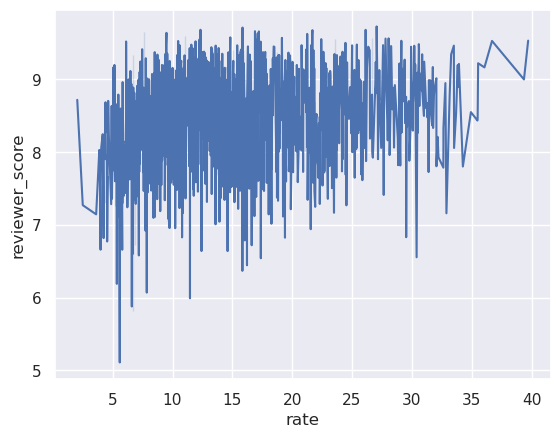

In [18]:
sns.lineplot(data=for_plot, x='rate', y='reviewer_score')

<AxesSubplot:xlabel='rate', ylabel='average_score'>

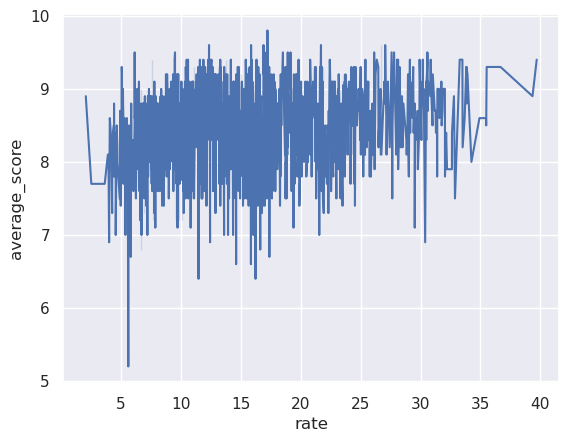

In [19]:
sns.lineplot(data=for_plot, x='rate', y='average_score')

Такое соотношение составляет от 2 до почти 40 процентов, при этом практически не зависит от общего количества отзывов (это можно увидеть, если поэкспериментировать с сортировкой таблицы). Мы можем предположить, что чем больше такой процент, тем меньше посетителей стимулируют оставлять отзывы. При этом разброс значений для оценок с увеличением этого показателя снижается. Скорее всего, это обусловлено тем, что уменьшается общее количество отзывов с ростом количества оценок, выставленных без отзыва. Наблюдается незначительный рост оценок с ростом этого показателя. Добавим в датасет такой параметр.

In [20]:
hotels['score_numbers_rate'] = hotels['additional_number_of_scoring'] / hotels['total_number_of_reviews']  

In [21]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Дата публикации отзыва (review_date)

Для начала преобразуем столбец в удобный формат.

In [22]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
min_date = hotels["review_date"].min().date()
max_date = hotels["review_date"].max().date()
print(f'В датасете данные представлены за период с {min_date} по {max_date}.')

В датасете данные представлены за период с 2015-08-04 по 2017-08-03.


Посмотрим на изменение данных с течением времени.

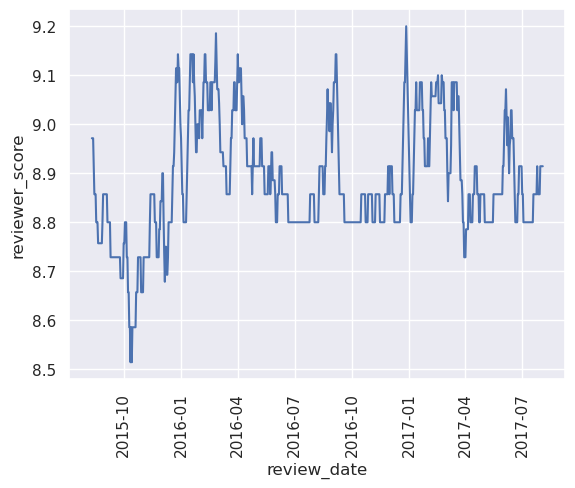

In [23]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='review_date')['reviewer_score'].median().rolling(7).mean()
plt.xticks(rotation=90)
plot = sns.lineplot(data=for_plot.reset_index()[7:], x='review_date', y='reviewer_score')

Разобьем данные по месяцам и оценим медианную оценку по отзывам. Для этого создадим новый категориальный признак — month_year. 

,reviewer_score
month_year,
2015-08,8.8
2015-09,8.8
2015-10,8.8
2015-11,8.8
2015-12,8.8
2016-01,9.2
2016-02,9.2
2016-03,9.2
2016-04,8.8


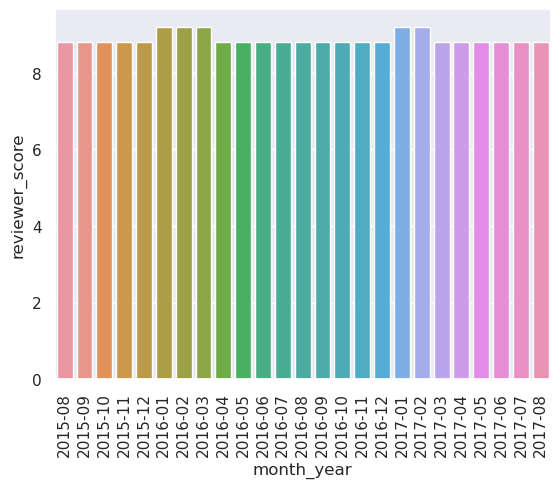

In [24]:
hotels['month_year'] = hotels['review_date'].dt.to_period('M')
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='month_year').agg({'reviewer_score' : 'median'})
plt.xticks(rotation=90)
sns.barplot(for_plot.reset_index(), x='month_year', y='reviewer_score')
for_plot

Медианная оценка выше в январе, феврале и марте 2016 года, а также в январе и феврале 2017 года — 9.2. В остальных — 8.8.

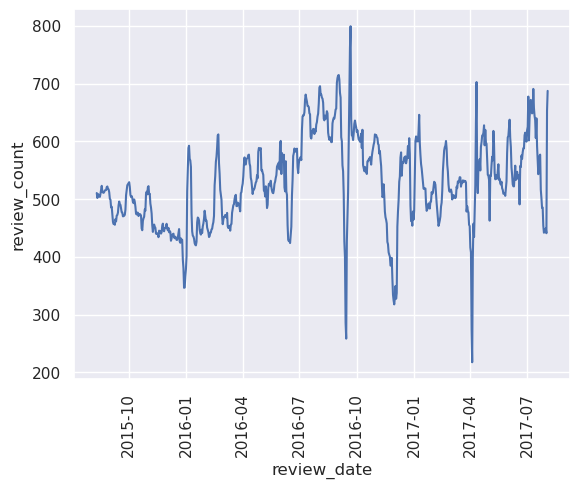

In [25]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='review_date')['reviewer_score'].count().rolling(7).mean()
plt.xticks(rotation=90)
plot = sns.lineplot(
    data=for_plot.reset_index()[7:].rename(columns={'reviewer_score' : 'review_count'}),
    x='review_date',
    y='review_count'
)

,review_count
month_year,
2015-08,14421
2015-09,14814
2015-10,14718
2015-11,13580
2015-12,13416
2016-01,14579
2016-02,14101
2016-03,15607
2016-04,16147


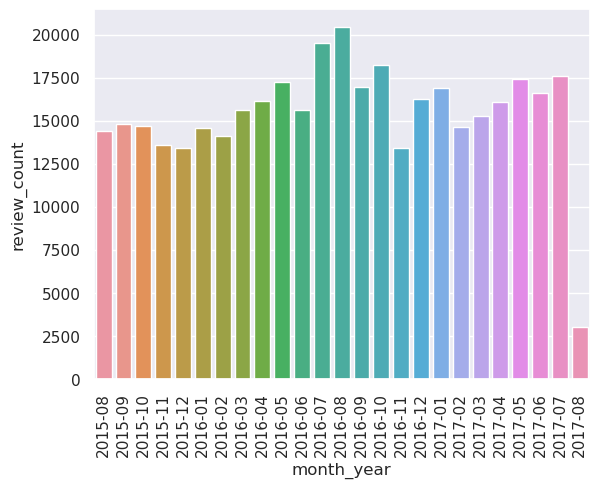

In [26]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='month_year').agg({'reviewer_score' : 'count'})
for_plot.rename(columns={'reviewer_score' : 'review_count'}, inplace=True)
plt.xticks(rotation=90)
sns.barplot(for_plot.reset_index(), x='month_year', y='review_count')
for_plot

Судя по графику, больше всего отзывов в июле и августе 2016 года — около 19500 и 20500 соответственно. Закодируем этот признак.

In [27]:
def high_months(period):
    string = str(period)
    if string == '2016-01' or string == '2016-02' or string == '2016-03' or string == '2017-02' or string == '2017-03':
        return 1
    return 0

hotels['high_months'] = hotels['month_year'].apply(high_months)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Средняя оценка (average_score)

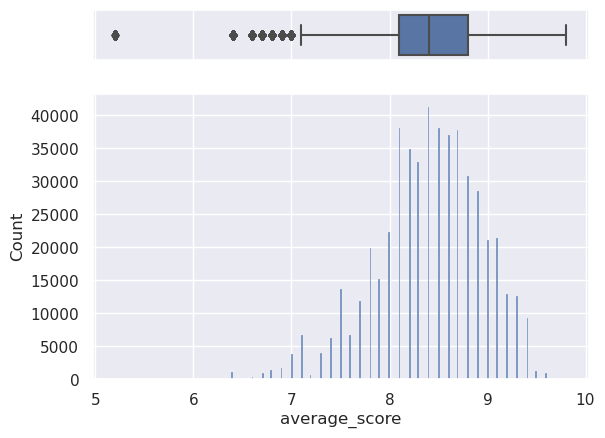

In [28]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x = hotels['average_score'], ax=ax_box)
sns.histplot(data=hotels, x='average_score', ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

In [29]:
min_avg_score = hotels['average_score'].min()
print(f'Минимальная средняя оценка: {min_avg_score}')

Минимальная средняя оценка: 5.2


Эта оценка особенно выбивается из ряда, давайте посмотрим, к какому отелю она относится.

In [30]:
mask1 = hotels['average_score'] == min_avg_score
mask2 = hotels['sample'] == 1
mask3 = (hotels['review_date'] >= '2016-01-01') & (hotels['review_date'] <= '2016-12-31')
print(f'Название отеля: {hotels[mask1]["hotel_name"].unique()[0]}')
print(f'Средняя оценка по отзывам: {hotels[mask1 & mask2 & mask3]["reviewer_score"].mean()}')
hotels[mask1 & mask2][['review_date', 'reviewer_score']].sort_values(by='review_date')

Название отеля: Hotel Liberty
Средняя оценка по отзывам: 5.342105263157896


,review_date,reviewer_score
469384,2015-09-10,6.3
398418,2015-09-10,7.5
293646,2015-09-18,3.8
373407,2015-10-01,6.7
505949,2015-10-03,7.1
467841,2015-10-08,5.4
286215,2015-11-17,4.2
344674,2015-11-22,5.4
229423,2016-04-06,4.0
284749,2016-04-06,6.7


Судя по всему, данные соответствуют действительности, поэтому удалять их не будем.

## Название отеля (hotel_name)

Это уникальный идентификатор каждого отеля. Давайте посмотрим, сколько уникальных записей.

In [31]:
unique_names = hotels['hotel_name'].unique().shape[0]
print(f'Уникальных названий отелей: {unique_names}')

Уникальных названий отелей: 1492


## Национальность (reviewer_nationality)

Нациаональность автора отзыва — интересный признак, который может влиять на оценку отеля. Давайте узнаем, сколько всего национальностей представлено в датафрейме.

In [32]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
number_of_nationalities = hotels['reviewer_nationality'].unique().shape[0]
print(f'Количество национальностей в дата-фрейме: {number_of_nationalities}')

Количество национальностей в дата-фрейме: 227


Давайте теперь посмотрим, из какой же страны больше всего туристов, оставляющих отзывы.

In [33]:
display(hotels['reviewer_nationality'].value_counts())
mask = hotels['reviewer_nationality'] == 'United Kingdom'
display(hotels[mask].shape[0] / hotels.shape[0] * 100)

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
                             ...  
Comoros                          1
Anguilla                         1
Tuvalu                           1
Cape Verde                       1
Palau                            1
Name: reviewer_nationality, Length: 227, dtype: int64

47.55243941691324

На долю Великобритании приходится около 47,6% авторов отзывов. Давайте узнаем, сколько национальностей формируют 90% отзывов.

In [34]:
hotels['reviewer_nationality'].value_counts()[:35].sum() / hotels['reviewer_nationality'].value_counts().sum()

0.9028460187149289

Таких национальностей 35, давайте исследуем их.

In [35]:
nationalities = list(hotels['reviewer_nationality'].value_counts().index[:35])
mask = hotels['reviewer_nationality'].apply(lambda x: True if x in nationalities else False)

,reviewer_nationality,reviewer_score,unique_hotels,reviwers_count
0,Australia,9.2,1381,16239
1,Austria,8.8,724,1817
2,Belgium,8.3,1168,4529
3,Canada,9.2,1199,5984
4,China,8.8,941,2564
5,Czech Republic,8.8,712,1719
6,Egypt,8.3,716,1786
7,France,8.8,1263,5543
8,Germany,8.3,1211,5956
9,Greece,8.3,879,2536


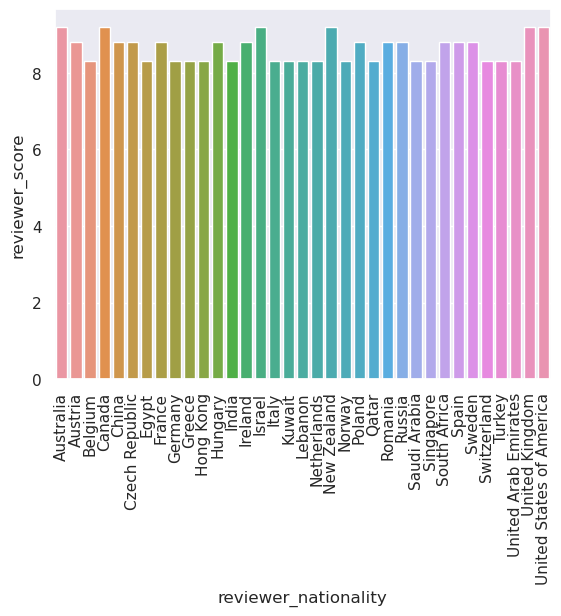

In [36]:
mask2 = hotels['sample'] == 1
for_plot = hotels[mask & mask2].groupby(by='reviewer_nationality').agg({
    'reviewer_score' : 'median',
    'hotel_name' : pd.Series.nunique,
    'review_date' : 'count'
}).reset_index()
for_plot.rename(columns={
    'hotel_name' : 'unique_hotels',
    'review_date' : 'reviwers_count'
}, inplace=True)
plt.xticks(rotation=90)
sns.barplot(for_plot, x='reviewer_nationality', y='reviewer_score')
for_plot

Самая низкая медианная оценка — 8.3, самая высокая — 9.2.

<AxesSubplot:xlabel='reviewer_nationality', ylabel='unique_hotels'>

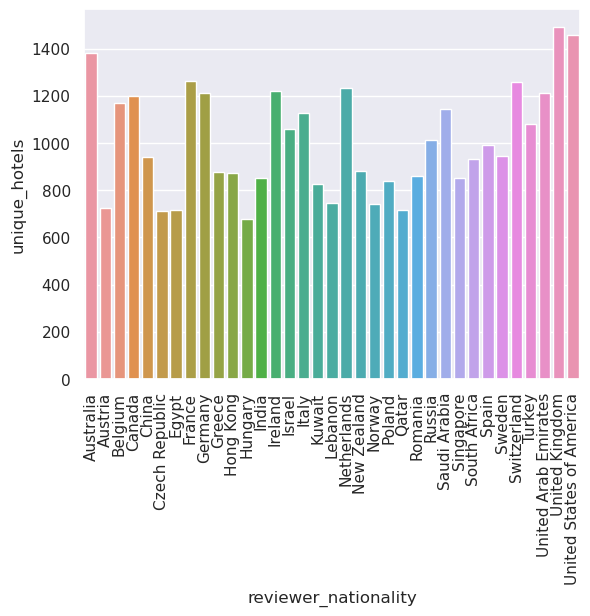

In [37]:
plt.xticks(rotation=90)
sns.barplot(for_plot, x='reviewer_nationality', y='unique_hotels')

Самое большое количество разных отелей посещают англичане, американцы и австралицы.

<AxesSubplot:xlabel='reviewer_nationality', ylabel='reviwers_count'>

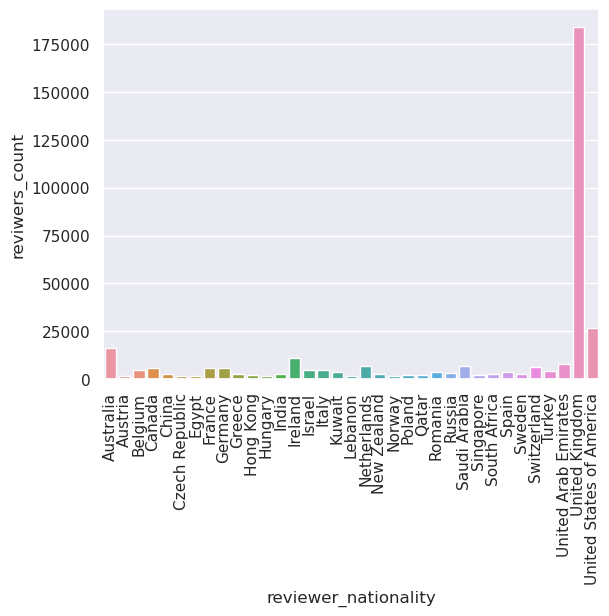

In [38]:
plt.xticks(rotation=90)
sns.barplot(for_plot, x='reviewer_nationality', y='reviwers_count')

Больше всего отзывов оставляют те же три нации, причем англичане здесь лидируют с большим отрывом (более чем в 6 раз больше отзывов, чем у ближайшего конкурента). Давайте создадим признак, показывающий, выезжал ли автор отзыва за пределы страны.

In [39]:
hotels['same_country'] = hotels[['reviewer_nationality', 'country']].apply(
    lambda x: 1 if x[0].lower()==x[1].lower() else 0, axis=1
)
categorical_columns.append('same_country')
hotels['same_country'].value_counts(normalize=True)

0    0.654082
1    0.345918
Name: same_country, dtype: float64

Таких туристов 34,6%. Мы помним, что самыми активными туристами являются англичане. Посмотрим, многие ли из них выезжают за пределы своей страны.

<AxesSubplot:xlabel='same_country', ylabel='reviwer_count'>

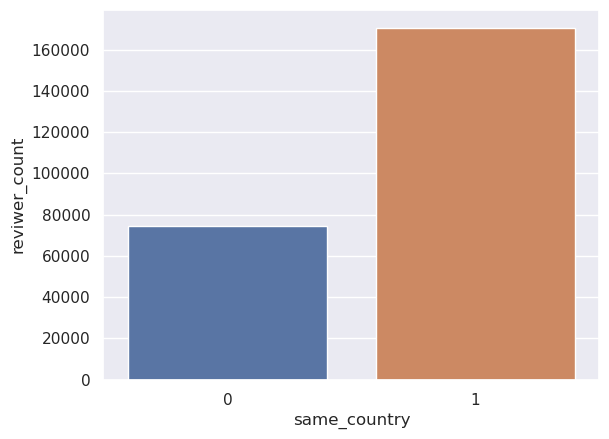

In [40]:
mask = hotels['reviewer_nationality'] == 'United Kingdom'
for_plot = hotels[mask].groupby(by='same_country').agg({'review_date' : 'count'})
for_plot.reset_index(inplace=True)
for_plot.rename(columns={'review_date' : 'reviwer_count'}, inplace=True)
sns.barplot(for_plot, x='same_country', y='reviwer_count')

За пределы своей страны не выезжают около 30% англичан. Закодируем признак национальности.

In [41]:
bin_enc = ce.BinaryEncoder(cols=['reviewer_nationality'])
data_bin = bin_enc.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, data_bin], axis=1).copy()
categorical_columns.extend(data_bin.columns)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Негативный отзыв (negative_review)

Проанализируем негативные отзывы с помощью библиотеки NLTK.

In [42]:
sent_analyzer = SentimentIntensityAnalyzer()
temp = hotels['negative_review'].apply(sent_analyzer.polarity_scores)
hotels['neg_neg'] = temp.apply(lambda x: dict(x)['neg'])
hotels['neg_neu'] = temp.apply(lambda x: dict(x)['neu'])
hotels['neg_pos'] = temp.apply(lambda x: dict(x)['pos'])

К сожалению, эта библиотека не всегда определяет ложноположительные результаты, такие как No negative, NA и т.д. Я создал список слов и словосочетаний, которые помогут нам определить такие варианты.

In [43]:
# загружаем датафрейм со словосочетаниями из подготовленного файла
negative_df = pd.read_csv('/kaggle/input/no-negative/no_negative.csv', sep=';')
display(negative_df)
# список словосочетаний, которые могут входиь в тег
negative_included = list(negative_df['included'])
# список словосочетаний, которые должны полностью совпадать с тегом
negative_whole = list(negative_df['whole'].unique())
negative_whole[-1] = ''

,included,whole
0,all amazing,absolutely nothing
1,all excellent,coming home
2,all fantastic,going home
3,all fine,good
4,all good,good location
...,...,...
88,was all good,NaN
89,we like everything,NaN
90,we liked everything,NaN
91,we love everything,NaN


In [44]:
# функция возвращает значение 0, если отзыв не отрицательный, иначе возвращается длина строки
def no_negative(string):
    string = string.strip().lower()
    if string in negative_whole:
        return 0
    for words in negative_included:
        if words in string:
            return 0
    return len(string)

# обнулим количество слов для неотрицательных отзывов
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(no_negative)

In [45]:
# если отзыв не отрицательный, приравниваем к нулю отрицательную и нейтральную составляющие
# положительную составляющую приравниваем к 1
mask = hotels['review_total_negative_word_counts'] == 0
hotels.loc[mask, 'neg_neg'] = 0
hotels.loc[mask, 'neg_neu'] = 0
hotels.loc[mask, 'neg_pos'] = 1

## Позитивный отзыв (positive_review)

Позитивные отзывы также проанализируем с помощью библиотеки NLTK.

In [46]:
sent_analyzer = SentimentIntensityAnalyzer()
temp = hotels['positive_review'].apply(sent_analyzer.polarity_scores)
hotels['pos_neg'] = temp.apply(lambda x: dict(x)['neg'])
hotels['pos_neu'] = temp.apply(lambda x: dict(x)['neu'])
hotels['pos_pos'] = temp.apply(lambda x: dict(x)['pos'])

Здесь используем ту же схему, что и для отрицательных отзывов, потому что библиотека плохо справляется с ложно положительными результатами.

In [47]:
no_positive = [
    'no positive', 'nothing', 'n a', 'na', 'none', '', 'not much', 'not a lot', 'nothing at all', 'leaving', 'nothing special',
    'nothing really', 'no', 'no thing', 'very little', 'absolutely nothing', 'nothing much', 'nothing in particular',
    'checking out'
]
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(
    lambda x: 0 if x.strip().lower() in no_positive else len(x)
)

In [48]:
mask = hotels['review_total_positive_word_counts'] == 0
hotels.loc[mask, 'pos_neg'] = 1
hotels.loc[mask, 'pos_neu'] = 0
hotels.loc[mask, 'pos_pos'] = 0

In [49]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Количество слов в негативном отзыве (review_total_negative_word_counts)

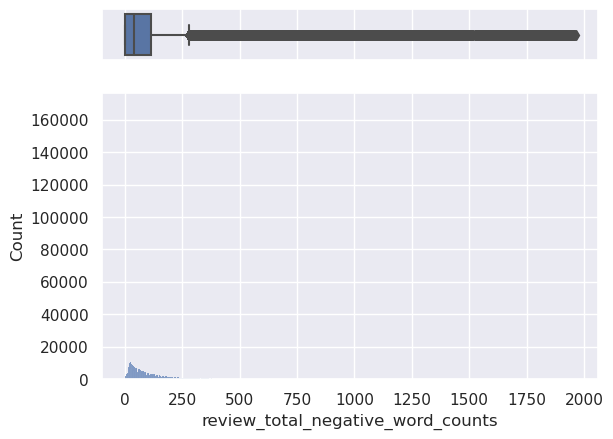

In [50]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=hotels['review_total_negative_word_counts'], ax=ax_box)
sns.histplot(data=hotels, x='review_total_negative_word_counts', ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

Больше всего отзывов, где нет негативных комментариев (более 160 000). В основном все комментарии не больше 250 слов.

## Количество слов в позитивном отзыве (review_total_positive_word_counts)

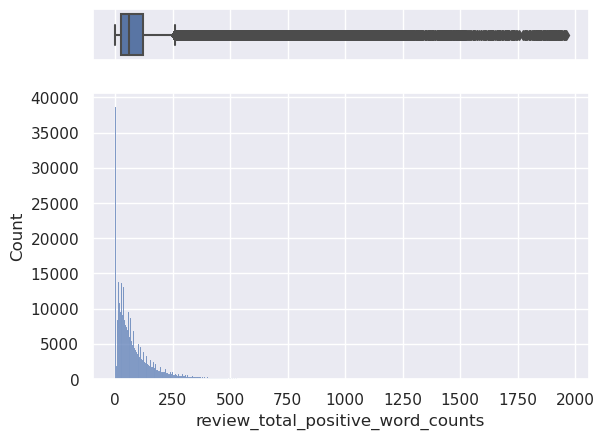

In [51]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=hotels['review_total_positive_word_counts'], ax=ax_box)
sns.histplot(data=hotels, x='review_total_positive_word_counts', ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

Отзывов, где нет положительных комментариев гораздо меньше (около 38 500). Здесь тоже основная часть комментариев меньше 250 слов.

In [52]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Общее количество отзывов (total_number_of_reviews)

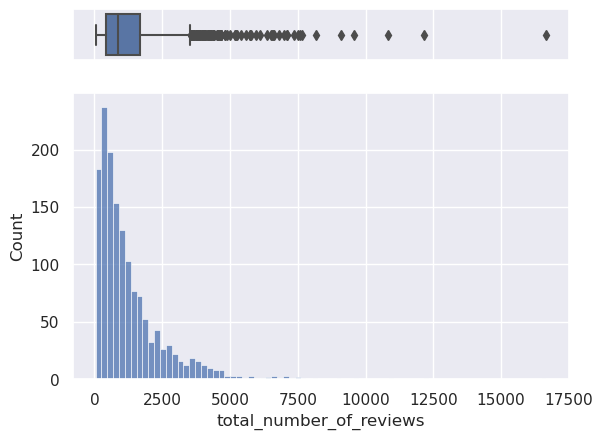

In [53]:
for_plot = hotels.groupby(by='hotel_name').agg({'total_number_of_reviews' : 'mean'})
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=for_plot['total_number_of_reviews'], ax=ax_box)
sns.histplot(data=for_plot, x='total_number_of_reviews', ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

Для большинства отелей общее количество отзывов не превышает 5000.

<AxesSubplot:xlabel='total_number_of_reviews', ylabel='reviewer_score'>

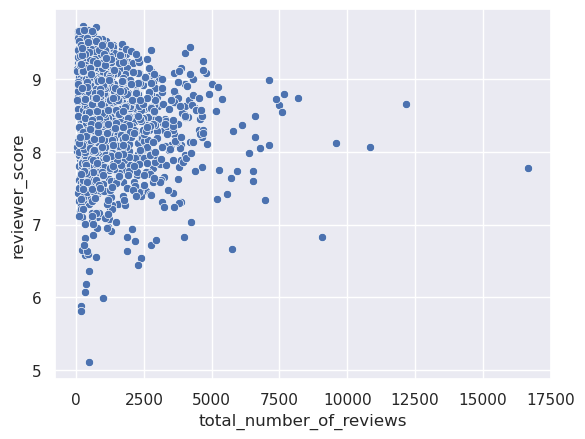

In [54]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='hotel_name').agg({'total_number_of_reviews' : 'mean', 'reviewer_score' : 'mean'})
sns.scatterplot(data=for_plot, x="total_number_of_reviews", y="reviewer_score")

Связи со средней оценкой отзывов не наблюдается.

<AxesSubplot:xlabel='total_number_of_reviews', ylabel='average_score'>

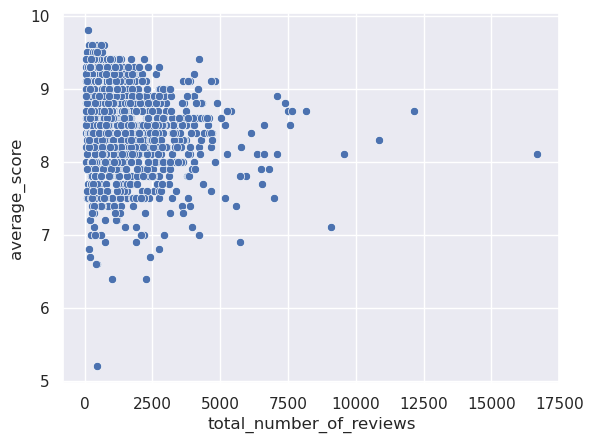

In [55]:
for_plot = hotels.groupby(by='hotel_name').agg({'total_number_of_reviews' : 'mean', 'average_score' : 'mean'})
sns.scatterplot(data=for_plot, x="total_number_of_reviews", y="average_score")

Очевидной связи со средней оценкой отелей тоже не нет.

In [56]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Общее число отзывов этого автора (total_number_of_reviews_reviewer_has_given)

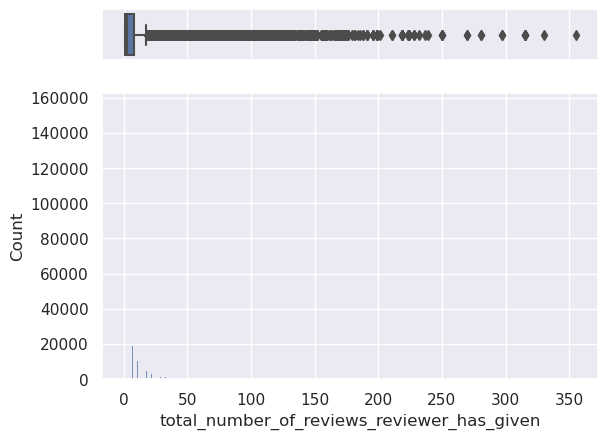

In [57]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=hotels['total_number_of_reviews_reviewer_has_given'], ax=ax_box)
sns.histplot(data=hotels, x='total_number_of_reviews_reviewer_has_given', ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

Большинство авторов дали первый свой отзыв. Основная часть авторов не дала больше 50 отзывов.

<AxesSubplot:xlabel='total_number_of_reviews_reviewer_has_given', ylabel='reviewer_score'>

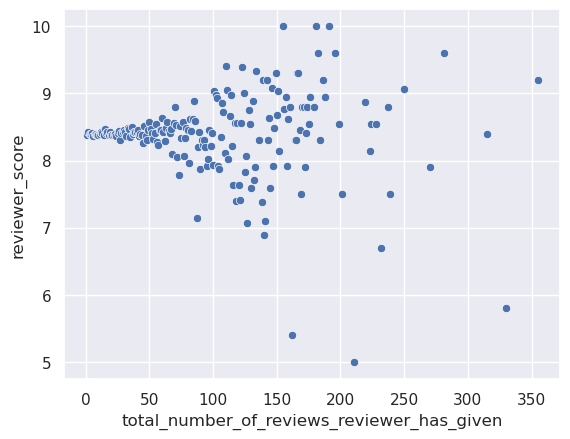

In [58]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='total_number_of_reviews_reviewer_has_given').agg({'reviewer_score' : 'mean'})
sns.scatterplot(data=for_plot, x="total_number_of_reviews_reviewer_has_given", y="reviewer_score")

Между количеством оценок и средней оценкой за отзыв не прослеживается связь.

## Теги (tags)

In [59]:
hotels['tags'][0]

"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

Для каждого отеля указано несколько тегов. Посмотрим, одинаковое ли это количество.

In [60]:
temp = hotels['tags'][2:-2].apply(lambda x: len(x.split(', ')))
min_count = temp.min()
max_count = temp.max()
total_count = temp.sum()
print(f'Для каждого отеля указано от {min_count} до {max_count} тегов, а всего их — {total_count:,}')

Для каждого отеля указано от 1 до 6 тегов, а всего их — 2,356,576


Посмотрим, сколько всего разных тегов.

In [61]:
temp = hotels['tags'].copy().apply(lambda x: x[2:-2].split("', '"))
temp = temp.apply(lambda x: [y.lower() for y in x])
display(temp.explode().value_counts().head())
all_tags = pd.Series(temp.explode().value_counts().index)


 leisure trip                       417778
 submitted from a mobile device     307640
 couple                             252294
 stayed 1 night                     193645
 stayed 2 nights                    133937
Name: tags, dtype: int64

Всего 2421 тег. Я проанализировал их вручную, чтобы выделить отдельные категории или распространенные теги. Для этого я использовал наиболее популярные ключевые слова.

In [62]:
temp2 = temp.explode().apply(lambda x: x.strip().split(' '))
all_tag_words = list(temp2.explode().value_counts().index)
all_tag_words[:25]

['stayed',
 'trip',
 'room',
 'leisure',
 'nights',
 'a',
 'from',
 'mobile',
 'submitted',
 'device',
 'double',
 'couple',
 '1',
 'night',
 '2',
 'with',
 'twin',
 'solo',
 'traveler',
 '3',
 'family',
 'or',
 'children',
 'standard',
 'superior']

Первое ключевое слово — stayed. С ним связаны теги, которые указывают количество ночей, проведенных в отеле.

In [63]:
pop_tags = all_tags.apply(lambda x: x if (' stayed ') in x.lower() else np.NaN)
pop_tags.unique()

array([nan, ' stayed 1 night ', ' stayed 2 nights ', ' stayed 3 nights ',
       ' stayed 4 nights ', ' stayed 5 nights ', ' stayed 6 nights ',
       ' stayed 7 nights ', ' stayed 8 nights ', ' stayed 9 nights ',
       ' stayed 10 nights ', ' stayed 11 nights ', ' stayed 12 nights ',
       ' stayed 14 nights ', ' stayed 13 nights ', ' stayed 15 nights ',
       ' stayed 16 nights ', ' stayed 17 nights ', ' stayed 18 nights ',
       ' stayed 19 nights ', ' stayed 21 nights ', ' stayed 20 nights ',
       ' stayed 27 nights ', ' stayed 30 nights ', ' stayed 23 nights ',
       ' stayed 22 nights ', ' stayed 25 nights ', ' stayed 28 nights ',
       ' stayed 26 nights ', ' stayed 24 nights ', ' stayed 29 nights ',
       ' stayed 31 nights '], dtype=object)

In [64]:
temp = hotels['tags'].apply(lambda x: 1 if ' stayed ' in x.lower() else 0)
temp.value_counts()

1    515546
0       192
Name: tags, dtype: int64

Тег такой категории не указан для 192 отелей. Добавим категорию nights_stayed (количество ночей в отеле). Для записей, где отсутствует этот тег в категории укажем 0.

In [65]:
def get_nights_stayed(string):
    tag_list = string[2:-2].split(', ')
    for tag in tag_list:
        if 'stayed' in tag.lower():
            words = tag.strip().lower().split(' ')
            return int(words[words.index('stayed') + 1])
    return 0

hotels['nights_stayed'] = hotels['tags'].apply(get_nights_stayed)
hotels['nights_stayed'].value_counts().head()

1    193645
2    133937
3     95821
4     47817
5     20845
Name: nights_stayed, dtype: int64

<AxesSubplot:xlabel='nights_stayed', ylabel='reviewer_score'>

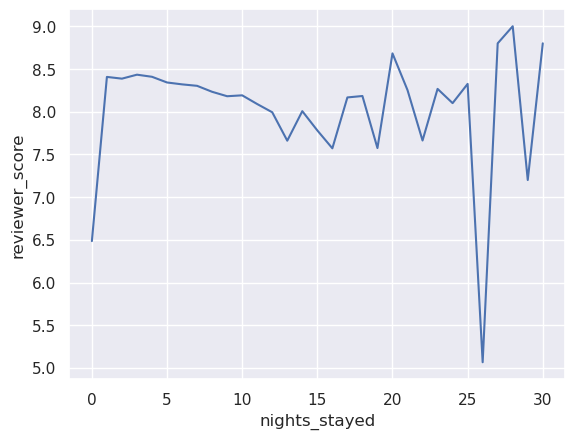

In [66]:
mask = hotels['sample'] == 1
for_plot = hotels[mask].groupby(by='nights_stayed')['reviewer_score'].mean()
sns.lineplot(for_plot)

<AxesSubplot:xlabel='nights_stayed', ylabel='reviewer_score'>

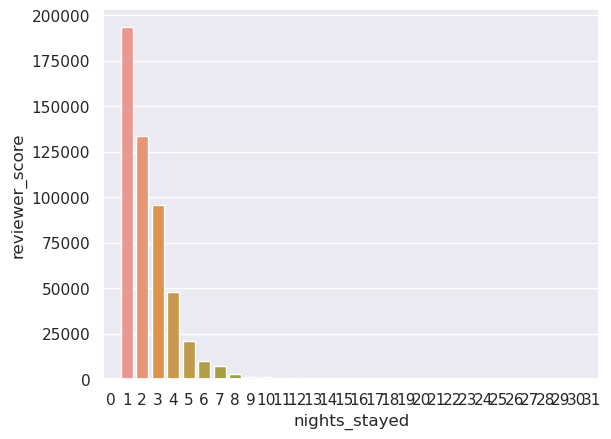

In [67]:
for_plot = hotels.groupby(by='nights_stayed')['reviewer_score'].count()
sns.barplot(for_plot.reset_index(), x='nights_stayed', y='reviewer_score')

Большинство посетителей остаются только на одну ночь. Редко кто проводит в отеле больше 7 ночей. Закодируем признак.

In [68]:
bin_enc = ce.BinaryEncoder(cols=['nights_stayed'])
data_bin = bin_enc.fit_transform(hotels['nights_stayed'])
hotels = pd.concat([hotels, data_bin], axis=1).copy()
categorical_columns.extend(data_bin.columns)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

Следующие два популярных тега относятся к отдыху (leisure trip) и командировкам (business trip). Создадим признак trip, в котором будут ри категории — leisure trip, business trip и other.

In [69]:
def trip(string):
    string = string.lower()
    if ' leisure trip ' in string:
        return 'leisure trip'
    if ' business trip ' in string:
        return 'business trip'
    return 'other'

hotels['trip'] = hotels['tags'].apply(trip)
hotels['trip'].value_counts(normalize=True)

leisure trip     0.810059
business trip    0.160816
other            0.029125
Name: trip, dtype: float64

<AxesSubplot:xlabel='trip', ylabel='reviewer_score'>

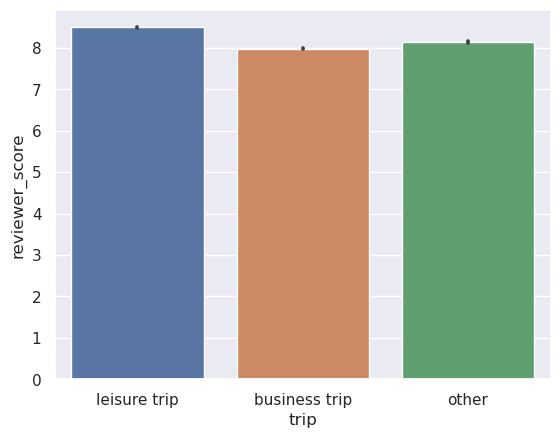

In [70]:
mask = hotels['sample'] == 1
sns.barplot(data=hotels[mask], x='trip', y='reviewer_score')

Закодируем этот признак.

In [71]:
ohe_enc = ce.OneHotEncoder(cols=['trip'])
data_ohe = ohe_enc.fit_transform(hotels['trip'])
categorical_columns.extend(data_ohe.columns)
hotels = pd.concat([hotels, data_ohe], axis=1)

Еще один часто встречающийся тег — submitted from a mobile device. Создадим для него отдельный признак.

In [72]:
hotels['from_mobile_device'] = hotels['tags'].apply(lambda x: 1 if ' submitted from a mobile device ' in x.lower() else 0)
categorical_columns.append('from_mobile_device')
hotels['from_mobile_device'].value_counts(normalize=True)

1    0.596504
0    0.403496
Name: from_mobile_device, dtype: float64

Следующая категория — количество и вместимость комнат. Создадим признак room со значениями double room, two room, triple room, single room и other.

In [73]:
def room(string):
    string = string.lower()
    if (' double room ' in string) or (' twin room ' in string):
        return 'double room'
    if ' 2 rooms ' in string:
        return 'two room'
    if ' triple room ' in string:
        return 'triple room'
    if ' single room ' in string:
        return 'single room'
    return 'other'

hotels['room'] = hotels['tags'].apply(room)
hotels['room'].value_counts(normalize=True)

double room    0.638607
other          0.273317
single room    0.046452
two room       0.024030
triple room    0.017594
Name: room, dtype: float64

<AxesSubplot:xlabel='room', ylabel='reviewer_score'>

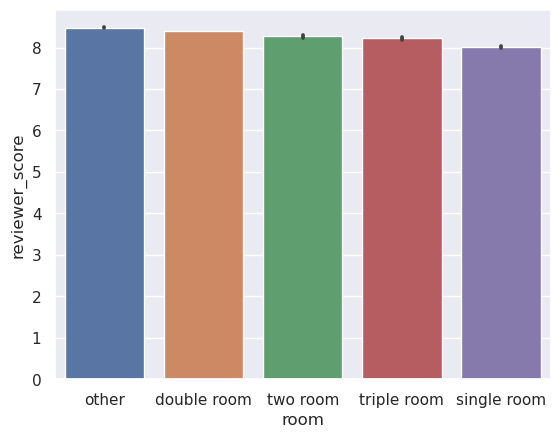

In [74]:
mask = hotels['sample'] == 1
sns.barplot(data=hotels[mask], x='room', y='reviewer_score')

Закодируем признак.

In [75]:
ohe_enc = ce.OneHotEncoder(cols=['room'])
data_ohe = ohe_enc.fit_transform(hotels['room'])
categorical_columns.extend(data_ohe.columns)
hotels = pd.concat([hotels, data_ohe], axis=1)

Следующий признак относится к количеству гостей, назовем его csg. Он будет принимать значения solo, couple, group и other.

In [76]:
def csg(string):
    string = string.lower()
    if ' solo ' in string:
        return 'solo'
    if ' couple ' in string:
        return 'couple'
    if ' group ' in string:
        return 'group'
    return 'other'

hotels['csg'] = hotels['tags'].apply(csg)
hotels['csg'].value_counts(normalize=True)

couple    0.489190
solo      0.210465
other     0.173551
group     0.126793
Name: csg, dtype: float64

<AxesSubplot:xlabel='csg', ylabel='reviewer_score'>

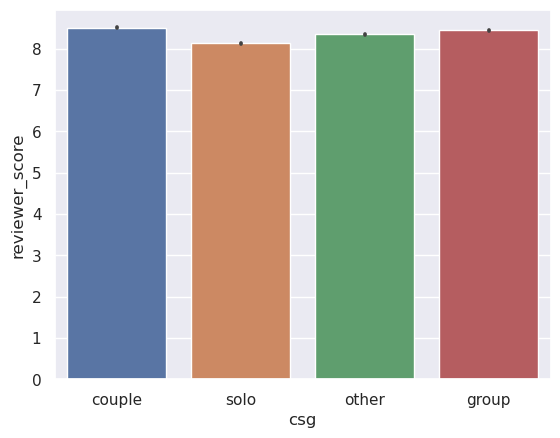

In [77]:
mask = hotels['sample'] == 1
sns.barplot(data=hotels[mask], x='csg', y='reviewer_score')

Закодируем признак.

In [78]:
ohe_enc = ce.OneHotEncoder(cols=['csg'])
data_ohe = ohe_enc.fit_transform(hotels['csg'])
categorical_columns.extend(data_ohe.columns)
hotels = pd.concat([hotels, data_ohe], axis=1)

Выделим отдельный признак family.

In [79]:
hotels['family'] = hotels['tags'].apply(lambda x: 1 if (' family ' in x.lower()) or (' children ' in x.lower()) else 0)
categorical_columns.append('family')
hotels['family'].value_counts()

0    426247
1     89491
Name: family, dtype: int64

<AxesSubplot:xlabel='family', ylabel='reviewer_score'>

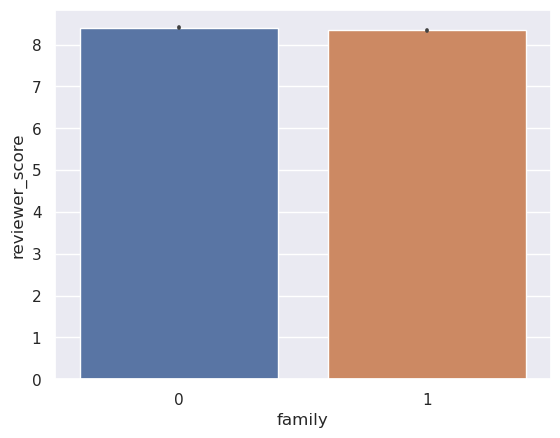

In [80]:
mask = hotels['sample'] == 1
sns.barplot(data=hotels[mask], x='family', y='reviewer_score')

Последний признак, который мы выделим с помощью тегов, — категория номера (category). Для него определим значения standard, deluxe и other.

In [81]:
def category(string):
    string = string.lower()
    if ' standard ' in string or ' classic ' in string:
        return 'standard'
    if ' deluxe ' in string or ' superior ' in string or ' executive ' in string or ' club ' in string:
        return 'deluxe'
    return 'other'

hotels['category'] = hotels['tags'].apply(category)
hotels['category'].value_counts(normalize=True)

other       0.413185
deluxe      0.347605
standard    0.239211
Name: category, dtype: float64

<AxesSubplot:xlabel='category', ylabel='reviewer_score'>

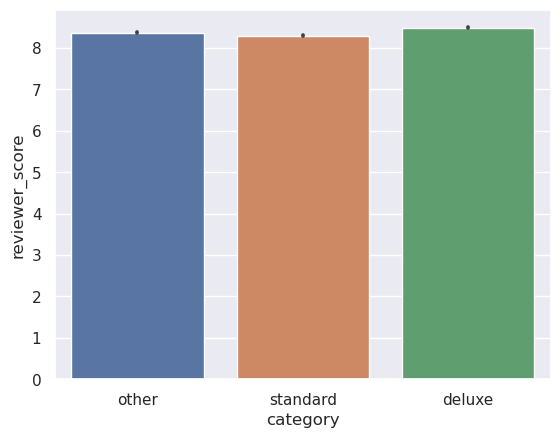

In [82]:
mask = hotels['sample'] == 1
sns.barplot(data=hotels[mask], x='category', y='reviewer_score')

In [83]:
ohe_enc = ce.OneHotEncoder(cols=['category'])
data_ohe = ohe_enc.fit_transform(hotels['category'])
categorical_columns.extend(data_ohe.columns)
hotels = pd.concat([hotels, data_ohe], axis=1)

In [84]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Количество дней, прошедших с момента оставления отчета до выгрузки данных (days_since_review)

Выделим количество дней и преобразуем в целочисленный формат.

In [85]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.strip().split(' ')[0]))

## Широта и долгота (lat и lng)

Это единственные исходные данные, которые заполнены не полностью. Устраним пробелы. Заполнить недостающие данные можно с помощью сведений о широте и долготе близлежащих отелей. Извлечем и столбца с адресом данные о почтовом индексе.

In [86]:
def get_postcode(string):
    words = string.split(' ')
    if 'Barcelona' in string or 'Vienna' in string or 'Milan' in string or 'Paris' in string:
        return words[-3]
    elif 'Amsterdam' in string or 'London' in string:
        return ' '.join(words[-4:-2])

hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

Найдем отели с такими же индексами и укажем недостающие значения как среднюю широту и долготу для отелей с такими же индексами.

In [87]:
mask1 = hotels['lat'].isna()
postcodes_list = list(hotels[mask1]['hotel_postcode'].unique())
for postcode in postcodes_list:
    mask2 = hotels['hotel_postcode'] == postcode
    hotels.loc[mask1 & mask2, 'lat'] = hotels.loc[~mask1 & mask2, 'lat'].mean()
    hotels.loc[mask1 & mask2, 'lng'] = hotels.loc[~mask1 & mask2, 'lng'].mean()

Добавим новый признак — расстояние от отеля до центра города, в котором он расположен.

In [88]:
def get_city(string):
    words = string.split(' ')
    if words[-2] == 'United':
        return words[-5]
    return words[-2]

hotels['city'] = hotels['hotel_address'].apply(get_city)

def distance_to_center(city, lat, lng):
    city_centers ={
        'London': (51.5085, -0.12574),
        'Barcelona': (41.3888, 2.15899),
        'Paris': (48.8534, 2.3488),
        'Amsterdam': (52.374, 4.88969),
        'Vienna': (48.2085, 16.3721),
        'Milan': (45.4643, 9.18951),
    }
    return haversine(city_centers[city], (lat, lng))

hotels['distance_to_center'] = hotels[['city', 'lat', 'lng']].apply(lambda x: distance_to_center(x[0], x[1], x[2]), axis=1)

# Очистка данных

## Уберем дублирующие строки

In [89]:
hotels.loc[hotels.duplicated(), 'valid'] = 0

## Удалим лишние столбцы

In [90]:
# выберем объекты типа object и удалим их
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)
# удалим столбцы, связанные с датой и периодом, а также nights_stayed, так как его мы закодировали
hotels.drop(['review_date', 'month_year', 'nights_stayed'], axis = 1, inplace=True)


In [91]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

## Мультиколлинеарность

Сначала рассмотрим категориальные признаки.

<AxesSubplot:>

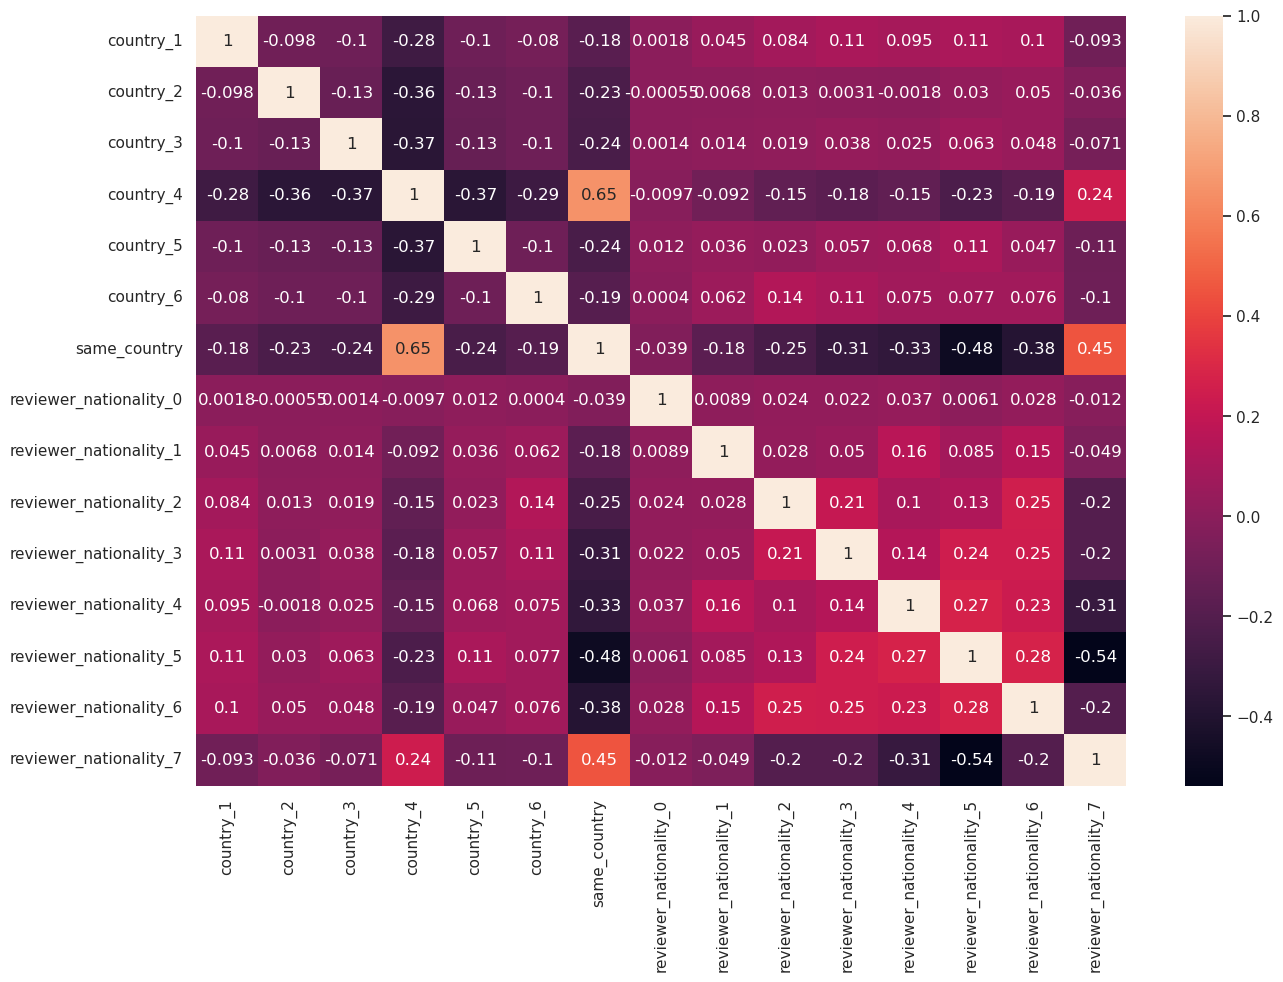

In [92]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels[categorical_columns[:15]].corr(method='spearman'), annot=True)

<AxesSubplot:>

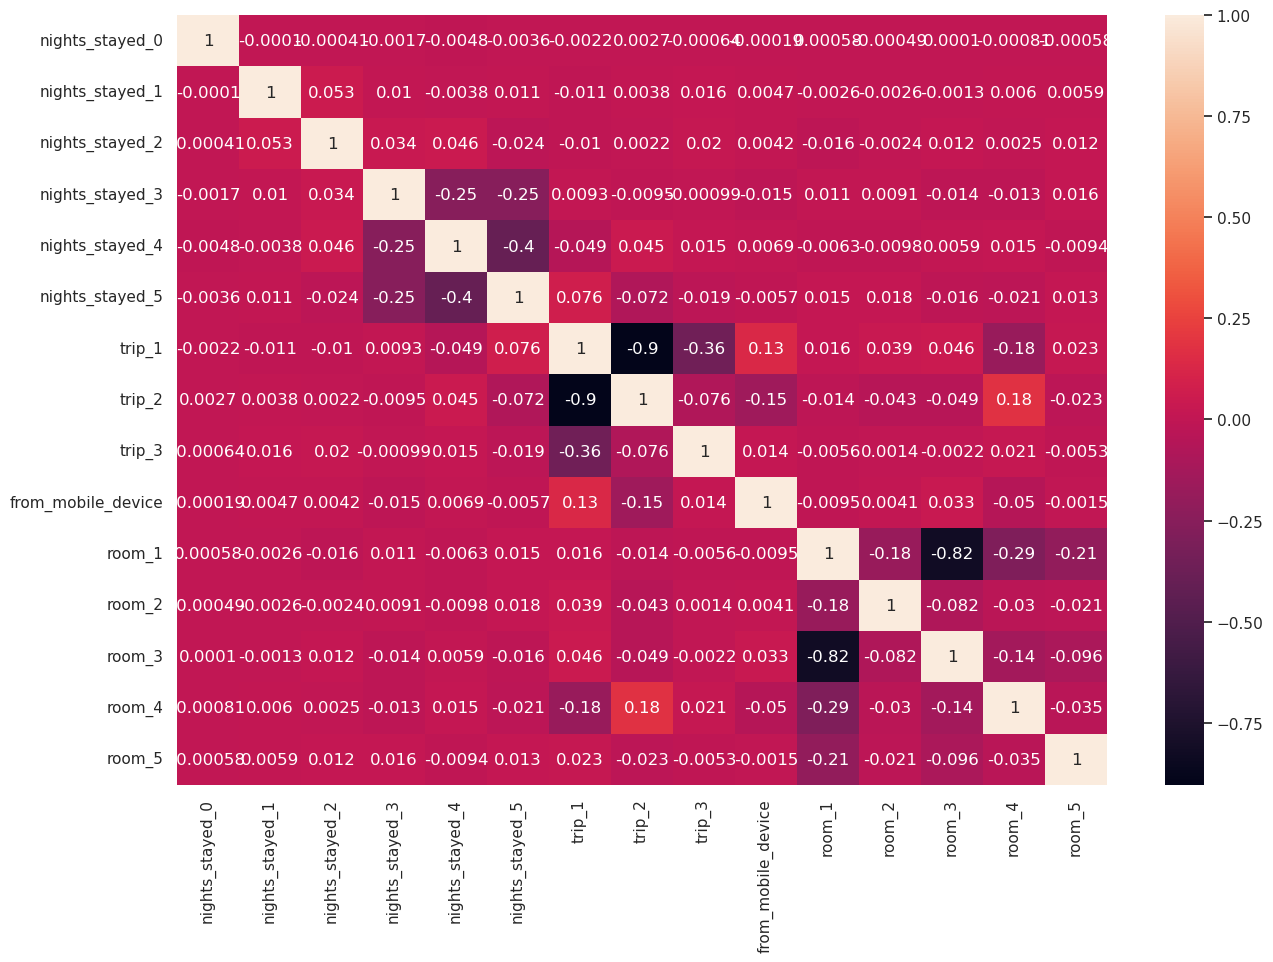

In [93]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels[categorical_columns[15:30]].corr(method='spearman'), annot=True)

<AxesSubplot:>

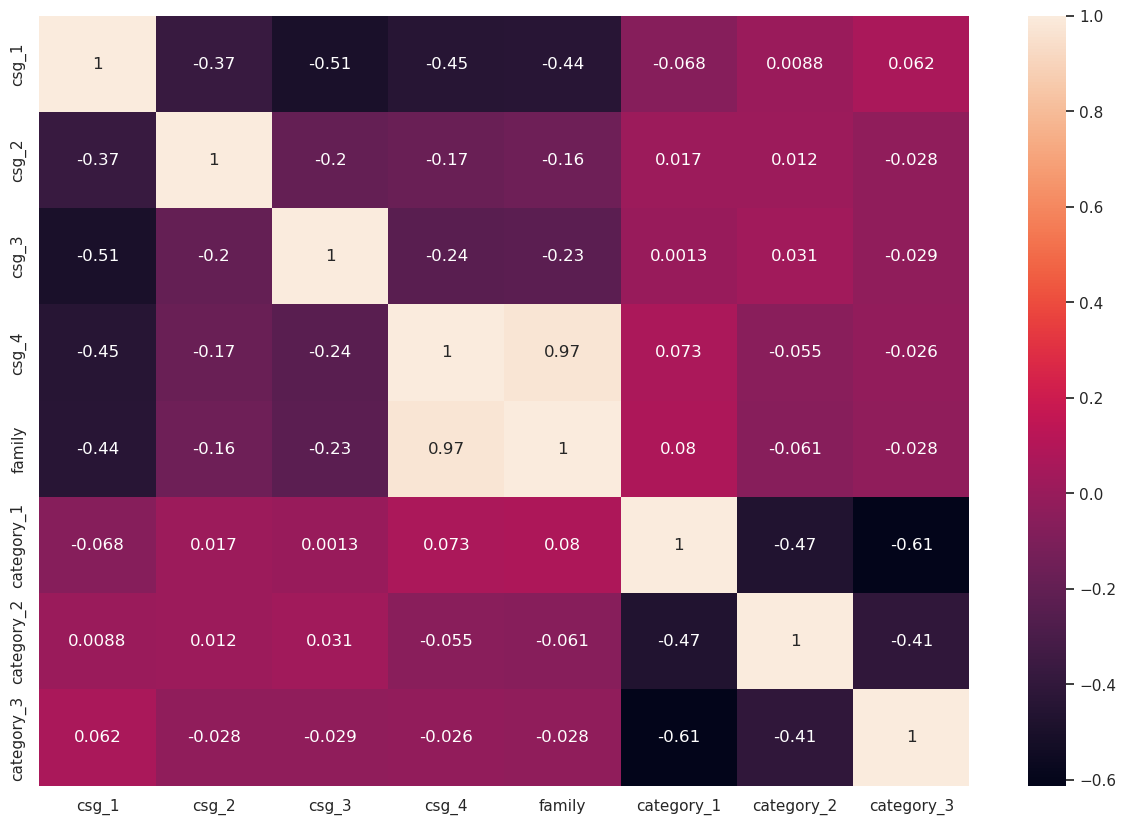

In [94]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels[categorical_columns[30:45]].corr(method='spearman'), annot=True)

<AxesSubplot:>

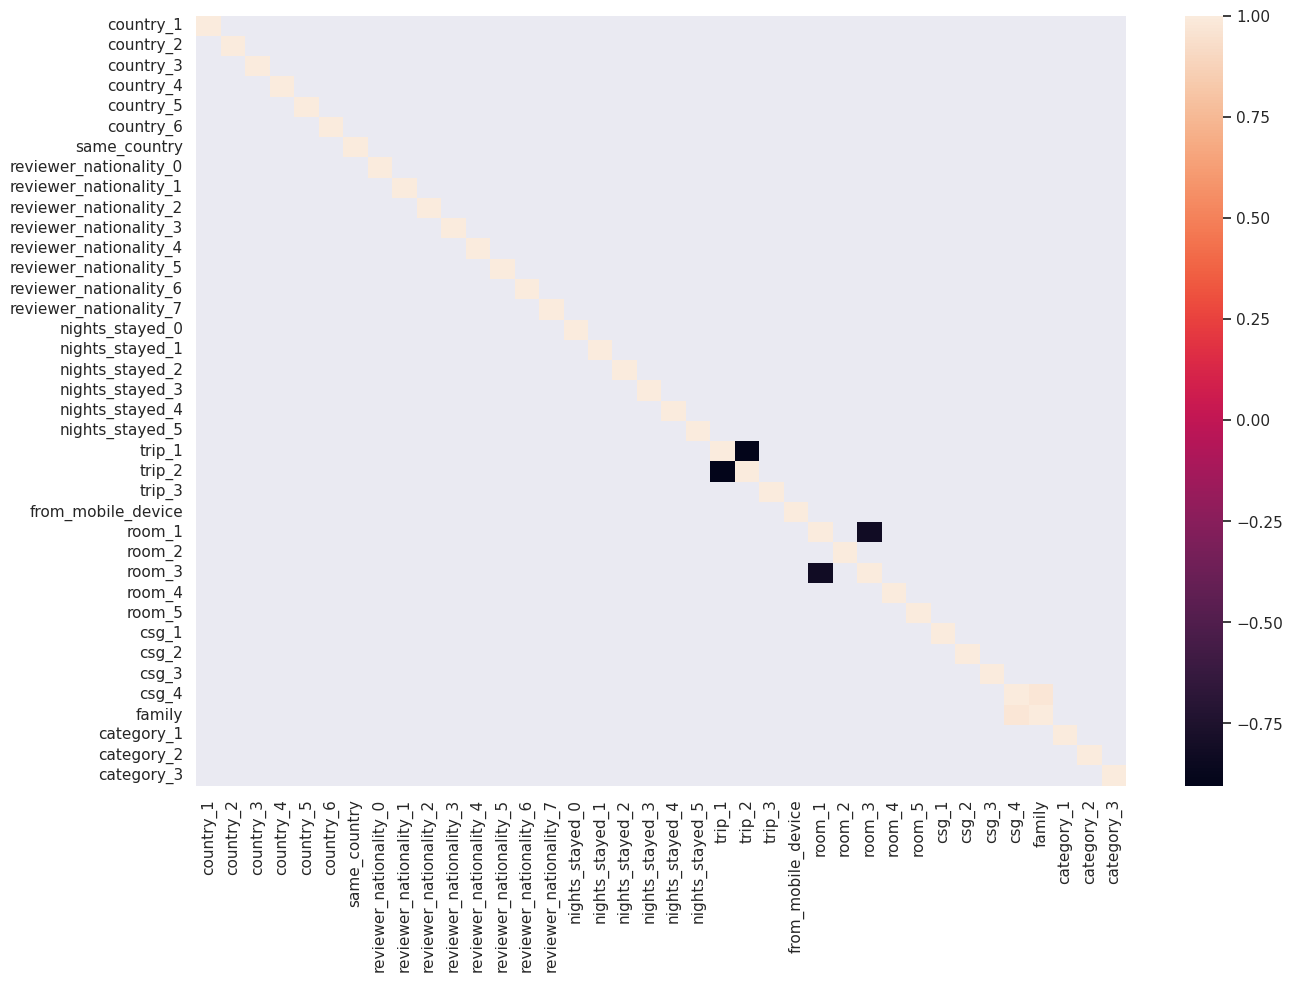

In [95]:
plt.rcParams['figure.figsize'] = (15,10)
categor_corr = hotels[categorical_columns].corr(method='spearman')
mask1 = hotels[categorical_columns].corr(method='spearman') >= 0.7
mask2 = hotels[categorical_columns].corr(method='spearman') <= -0.7
sns.heatmap(categor_corr[mask1 | mask2])

Несмотря на сильную корреляцию с другими признаками, мы не удалим trip_1, room_1 и family, так как с ними модель считает точнее.

Теперь рассмотрим некатегориальные признаки.

<AxesSubplot:>

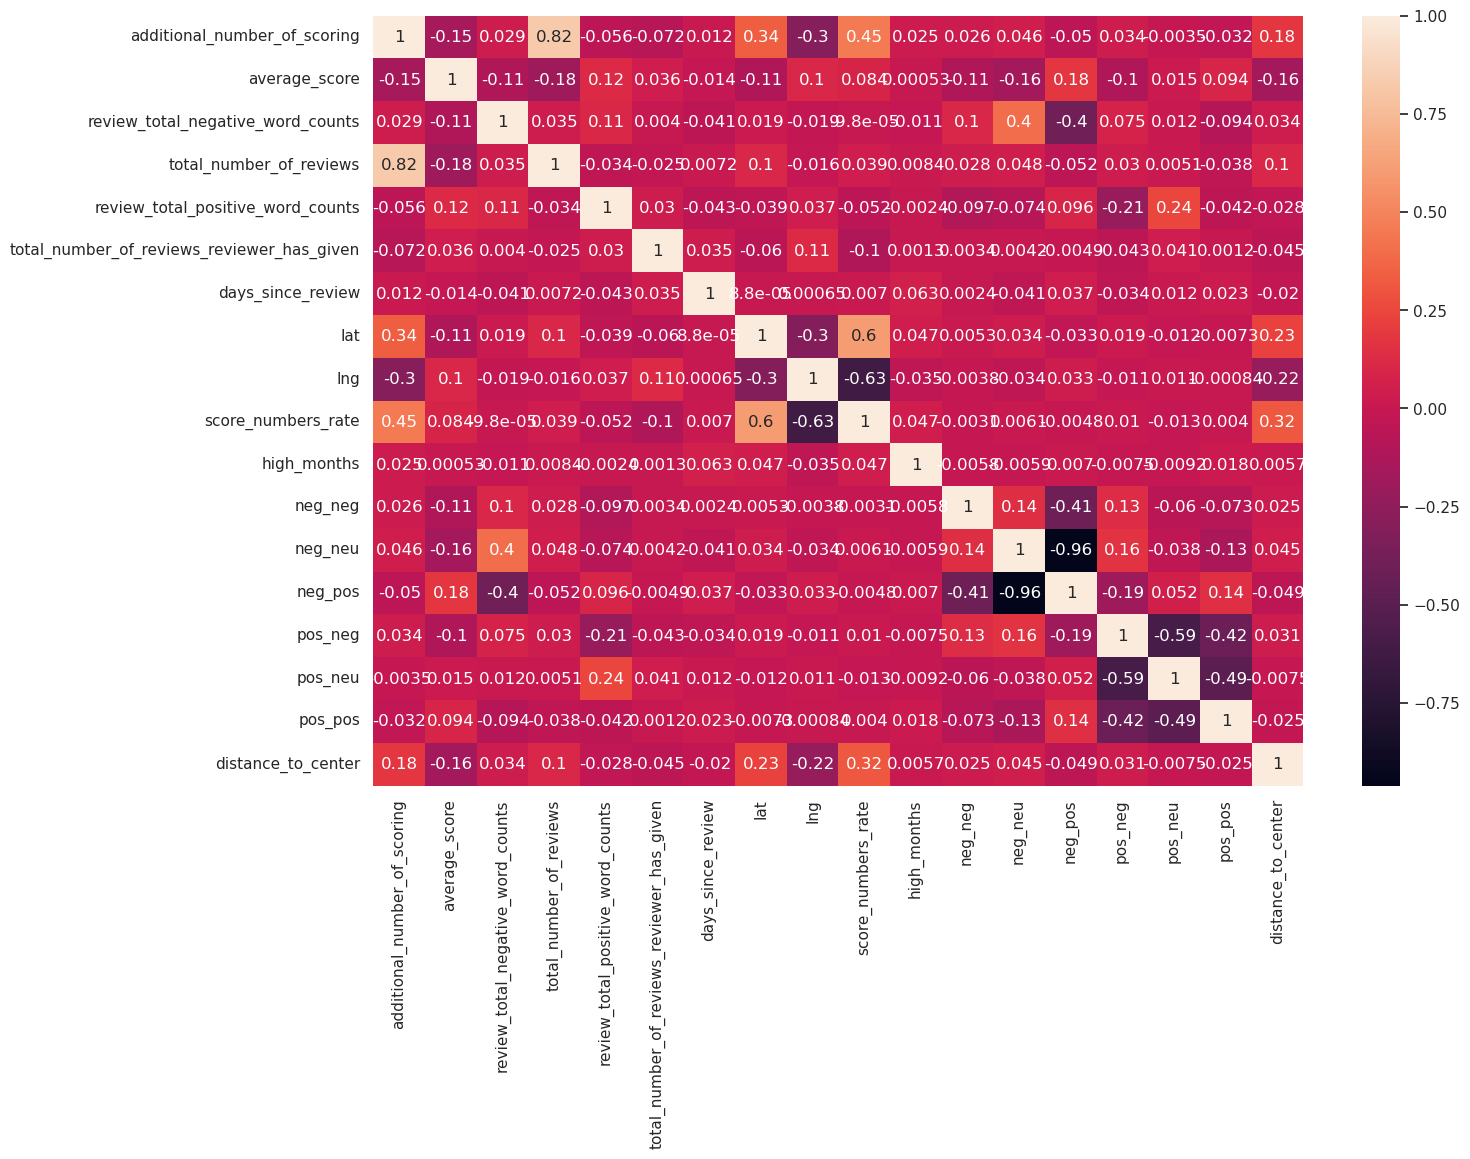

In [97]:
non_categorical_columns = [s for s in hotels.columns if s not in categorical_columns]
non_categorical_columns.remove('sample')
non_categorical_columns.remove('valid')
non_categorical_columns.remove('reviewer_score')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels[non_categorical_columns].corr(), annot=True)

Удалим столбцы additional_number_of_scoring и neg_neu.

In [98]:
hotels.drop([
    'additional_number_of_scoring',
    'neg_neu'
], axis = 1, inplace=True)

## Анализ значимости

<AxesSubplot:>

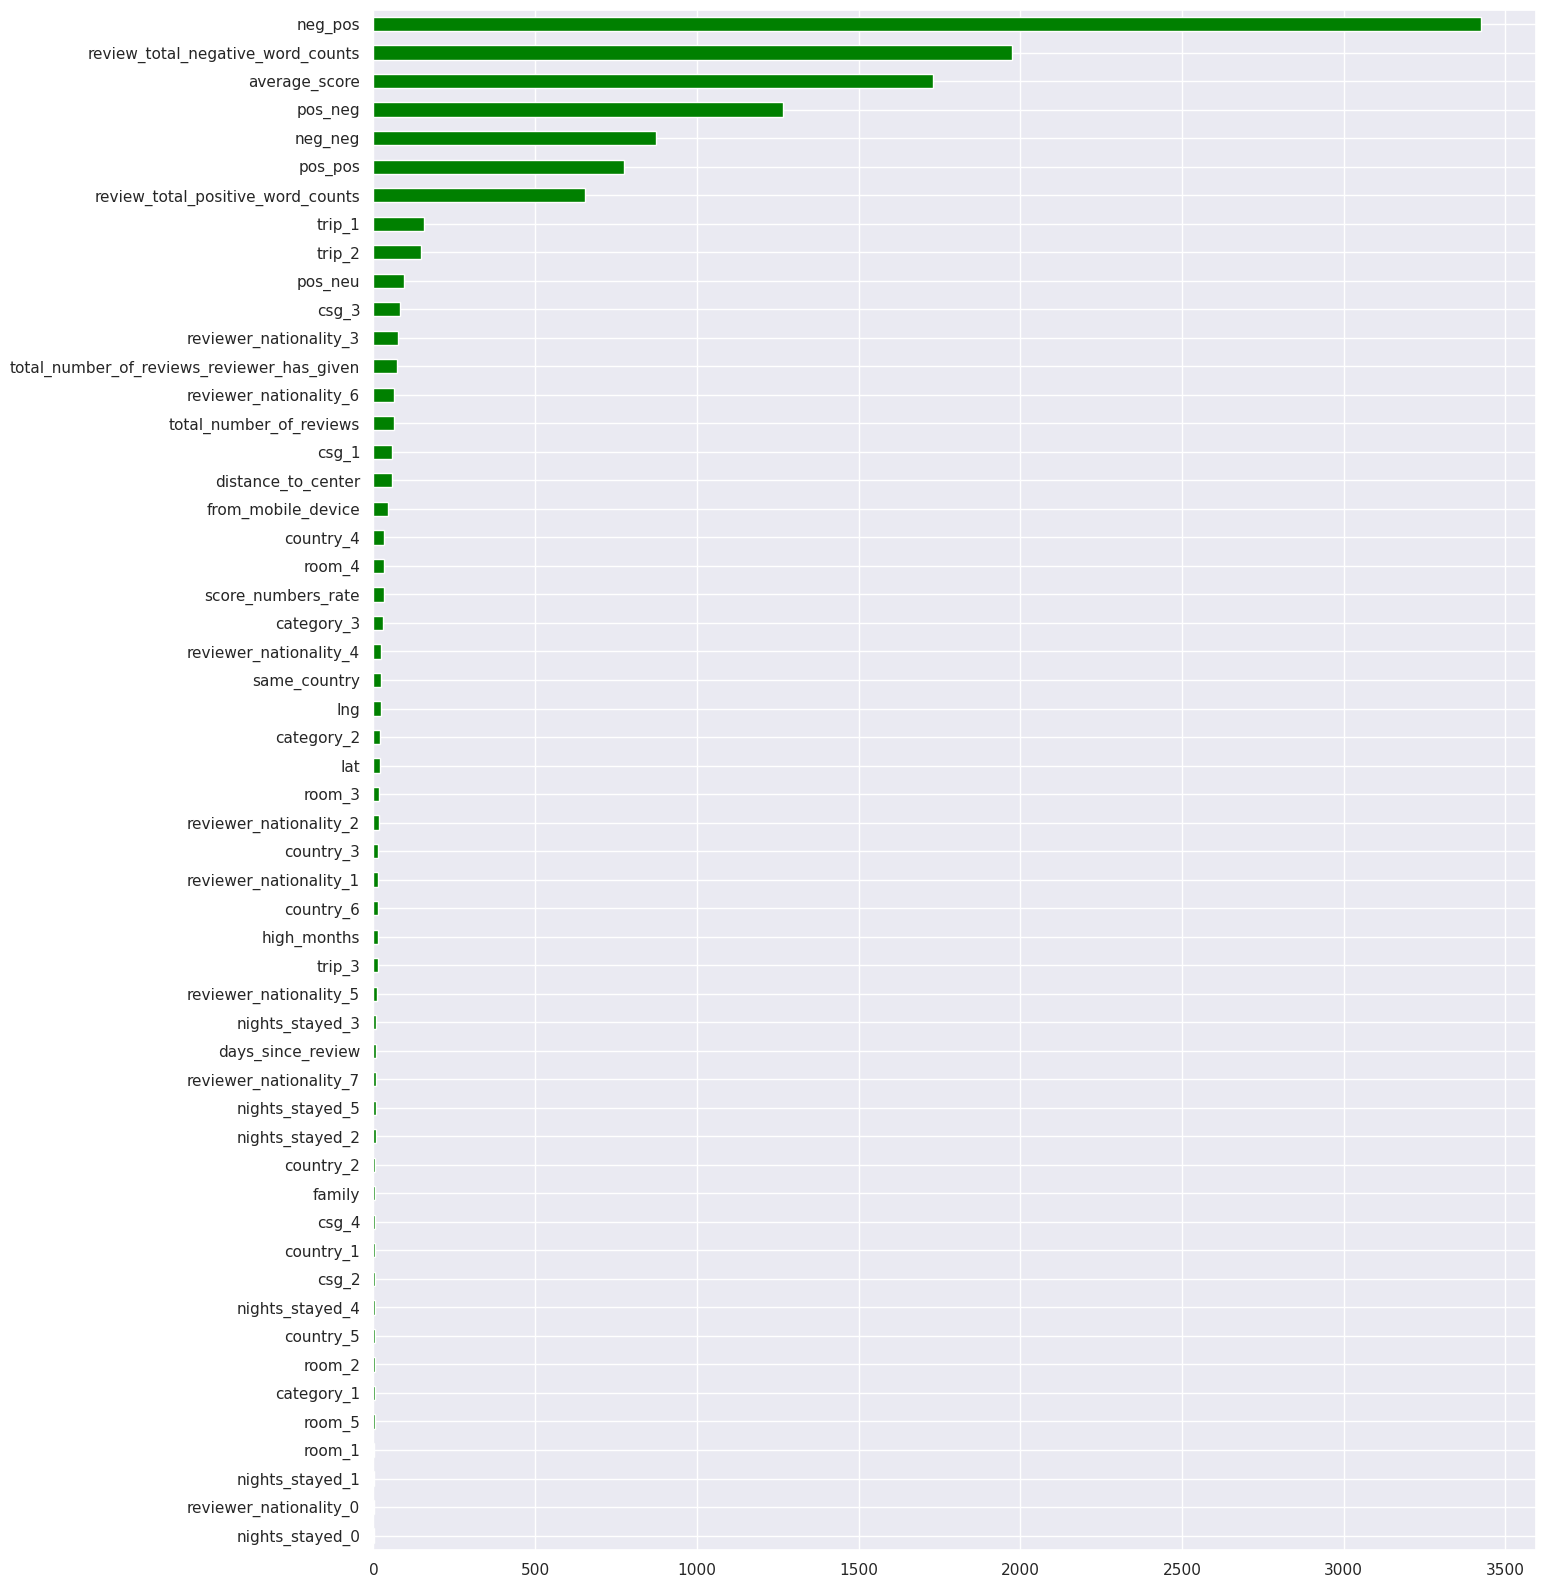

In [99]:
from sklearn.feature_selection import f_classif

y = hotels.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels.query('sample == 1').drop(['sample', 'reviewer_score', 'valid'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green')

# Машинное обучение и результаты

In [100]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1 and valid == 1').drop(['sample', 'valid'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample', 'valid'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [101]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [102]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 55), (386496, 55), (386496, 54), (309196, 54), (77300, 54))

In [103]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [104]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [105]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [106]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.4


<AxesSubplot:>

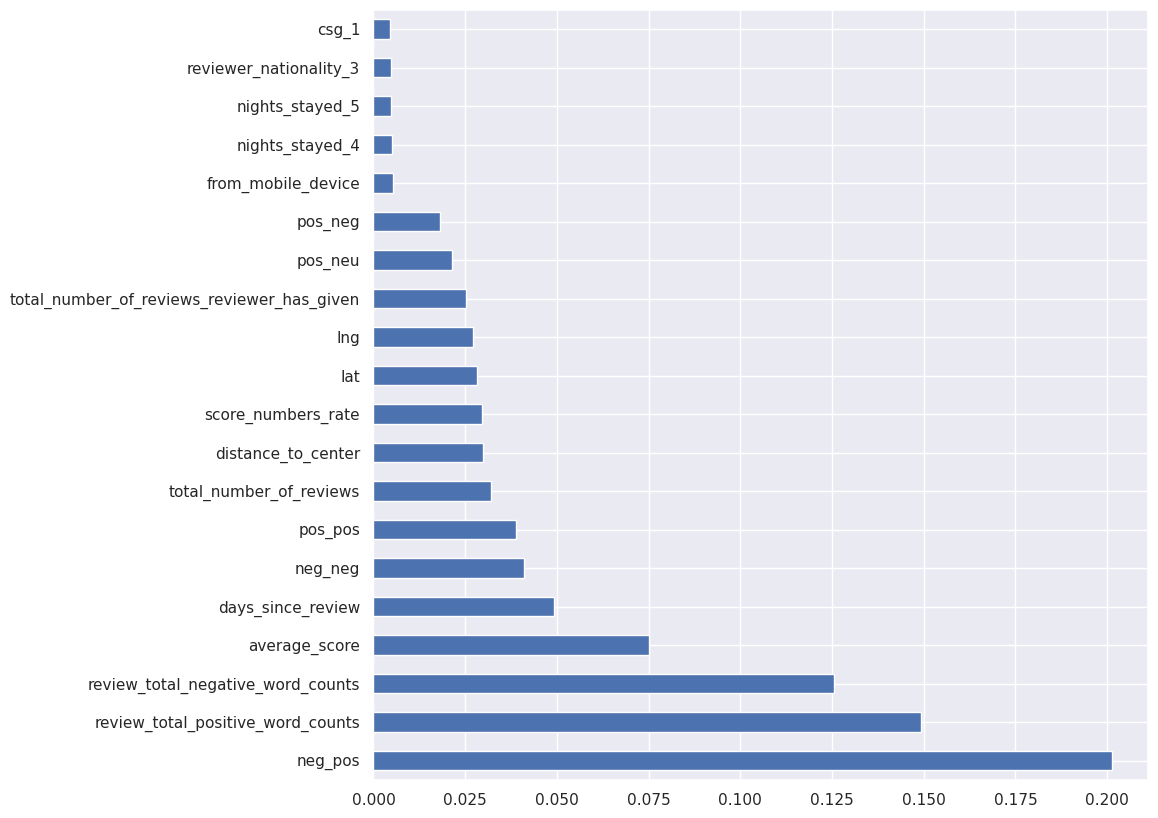

In [107]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [108]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,country_1,...,room_5,csg_1,csg_2,csg_3,csg_4,family,category_1,category_2,category_3,distance_to_center
53039,8.5,363,941,13,3,599,48.869169,2.333782,0.0,0,...,0,0,0,1,0,0,1,0,0,2.069148
36702,9.5,0,385,42,1,441,51.513981,-0.133795,0.0,0,...,0,1,0,0,0,0,0,0,1,0.825888
6906,8.4,72,6117,62,2,305,51.501400,-0.116009,0.0,0,...,0,1,0,0,0,0,0,0,1,1.037723
8759,7.3,51,2215,80,1,164,51.512745,-0.192644,0.0,0,...,0,1,0,0,0,0,0,0,1,4.654034
76362,8.0,0,2367,9,9,606,51.492514,-0.178792,0.0,0,...,0,0,0,1,0,0,1,0,0,4.079837
34613,8.1,47,1294,35,1,618,51.529257,-0.168358,0.0,0,...,0,1,0,0,0,0,0,0,1,3.744697
95533,8.5,120,2300,34,1,276,51.516517,-0.150974,0.0,0,...,0,1,0,0,0,0,0,0,1,1.960559
57418,7.8,52,1544,112,5,354,48.843707,2.315563,0.0,0,...,0,0,1,0,0,0,0,1,0,2.660145
110756,8.7,701,479,478,1,105,48.870961,2.326768,0.0,0,...,0,0,0,1,0,0,1,0,0,2.531919
34841,8.1,32,6608,9,1,673,51.513556,-0.180002,0.0,0,...,0,1,0,0,0,0,0,0,1,3.796981


In [109]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [110]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [111]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


In [112]:
predict_submission

array([8.806, 7.471, 8.202, ..., 7.725, 9.681, 7.497])

In [113]:
list(sample_submission)

['reviewer_score', 'id']

In [114]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.806,488440
1,7.471,274649
2,8.202,374688
3,9.686,404352
4,9.430,451596
5,9.070,302161
6,7.738,317079
7,7.715,13963
8,8.222,159785
9,7.670,195089
